In [1]:
import shap
import sklearn
shap.initjs()

# Import the adults dataset

In [2]:
X, y = shap.datasets.adult()

In [3]:
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39


# Dataset Description

Feature | Description
-------|----------
`target`| >50K, <=50K.
`age` | continuous.
`workclass` | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
`fnlwgt` |continuous.
`education` | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
`education-num` | continuous.
`marital-status` | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
`occupation` | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
`relationship` | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
`race`| White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
`sex`| Female, Male.
`capital-gain` | continuous.
`capital-loss` | continuous.
`hours-per-week` | continuous.
`native-country` | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.


# Context

The adults dataset contains information about the population of the United States. We'll try to understand which factors have more impact on predicting whether someone earns more than $50k money or not.

# First, you need to use the `train_test_split` to generate a test-dataset containing 20% of the public.


This will be helpful to hide some part of your dataset for future evaluation. You want to obtain your scores on this test dataset so as to better simulate the real world data that will come for you to predict in future. 

Use `from sklearn.model_selection import train_test_split` to obtain your train and test datasets

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_test.shape

(6513, 12)

# Using a complex model to predict whether someone earns more than $50k

Usually, when we are interested in interpretability, we have to rely on simple Machine Learning models like LogisticRegression or DecisionTrees. However, they usually have a lower performance as compared to more complex models. Complex models, however, lack of interpretability. That's where SHAP comes to the rescue.


For this example, we'll use one of the most common, but also most complex models in Machine Learning. It is called Lightgbm and it is a complex model based on DecisionTrees. Under the hood, it also performs lots of optimizations to enhance speed and accuracy of your results.

After installing `lightgbm` (`!pip install lightgbm`) on your machine, you'll be able to use the command `from lightgbm import LGBMClassifier` you'll be able to import the model.


In [7]:
from lightgbm import LGBMClassifier

After importing the model, use it to fit in your training data. You may use the default parameters of the LGBMClassifier for now.

In [8]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## We want to predict a single row of our dataset and understand why the model chose for that prediction.

Select a single row of your test dataset. You may use either a sampling method (for example, `X_test.sample(1)`) to randomly select an observation or you can specify the index of the row (for example, `X_test.iloc[[10],:]` to get the 10th index). The resulting row shall be in the format of a dataframe in this example.

Store the result in a variable called `single_row`.

In [9]:
# single_row = 
single_row = X_test.iloc[[10],:]
single_row

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
345,43.0,6,13.0,4,12,0,4,1,0.0,0.0,42.0,39


# Use your model to predict the probabilities that the observation earns more than $50k

Using your `model` you have fitted above, use the method `predict_proba` on the observation you stored in the variable `single_row`.

_Hint: Try to pick an observation that does not have too high probabilities (like ~0.99) for example. This will increase your understanding when using the `force_plot` below._ 

In [10]:
model.predict_proba(single_row)

array([[0.86173937, 0.13826063]])

How probable it is for the observation to earn more than $50k. 

Using a threshold of 50%, would the model decide that this observation received more than $50k a year or not?

In [11]:
model.predict_proba(single_row) > 0.5

array([[ True, False]])

# Use the TreeExplainer to start explaining the model

Shap has a specific class to handle complex models based on trees (namely lightgbm, xgboost and catboost). It is called TreeExplainer. If you have imported the package `shap`, you'll be able to call it via `shap.TreeExplainer()`.

The arguments the TreeExplainer expects are the model you are using (in this case, the variable you used stored and fitted the LGBMClassifier) and the training dataset you have used. 

The results of the shap.TreeExplainer is what is called an `explainer`. You'll use this object to explain the results in near future. Store it in a variable called `explainer`.

In [12]:
explainer = shap.TreeExplainer(model, X_train)
explainer

Passing 26048 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


# Calculate the SHAP values for the observation you've selected.

Using the SHAP package, you'll be able to calculate the feature importances using your `explainer`. 

Behind the scenes, it used `Game Theory` to observe how each feature is contributing to the score of the model. Use the method `explainer.shap_values` from your explainer to get these values of importance. As argument, you need to specify the observations you want to explain. For our case, we'll use the `single_row` created above for now. 

Store it in a variable called `values`.

In [13]:
values = explainer.shap_values(single_row)
values

array([[ 0.61167177, -0.26005812,  0.59912748, -0.3288546 ,  0.38746269,
        -0.62163706,  0.01948741,  0.18292579, -0.23390012, -0.02346995,
         0.16012248,  0.01390534]])

**Note:** For 1 single observation, this calculation is pretty fast. However, if you had more data, this computation would take forever. We'll see in the future how to overcome this problem.

# Understanding the prediction

SHAP has a visualization that helps you understand why the model took that decision. It is called `force_plot` because it simulates a (reversed) `tug of war` (cabo de guerra) in which each feature is pulling the chances of the event (in this case, the chances of earning more than $50k a year) of happening. 

The `force_plot` also used an argument named `base_value` which is the bias of your dataset. That is, the average of your predictions if for example you had no extra information. The features then start to pull and push the value of this `base_value` up or down.

The `red features` are the ones that increases the chance of the observation of earning more than $50k, while the `blue features` do the opposite. The size of the bar indicates how strongly that feature contributes to that decision.


Use the `shap.force_plot` explaining method to explore why the model decided for that decision. You'll be able to get the `base_value` via the attribute `explainer.expected_value`. It also requires the shapley values you calculated above (stored at `values`) and, finally, if you want to make the plot clearer, you can pass the observation as the argument `features` (`features = single_row` in our case).

In [14]:
base_value = explainer.expected_value
shap.force_plot(base_value, values, feature_names=X_train.columns)

Try to explain why the model took the decision you observed before. Remember to use the variables description for that. (Unfortunately, the dataset description is a little bit messy, but try your best =) )

Ok. So far we've understood a single observation. It would be useful if we could understand the decisions as a whole.

# Calculate the shap values for your whole test set!

Fortunately, we are able to calculate the Shapley values for the whole test dataset! We just have to repeat our process of estimating the Shapley values (via the `explainer.shap_values` method), but this time we need to pass the whole test dataset. 

**HOWEVER**, if you want to use the pure `shap_values` method, it will try to calculate the exact values and will take too long. If you want to speed up the process, you can calculate an approximation of those values. You just have to pass the argument `approximate=True` (try without it as well if you want to see how long it takes).

Store it in a variable called `values_test`

In [15]:
values_test = explainer.shap_values(X_test, approximate=True)

# A new way to visualize the `force_plot`

If you use the `force_plot` this time, you'll see a different visualization! Try specifying again, the `explainer.expected_value` (which is the base_value), the `values_test` above and your `test dataset`.

**Note**: If your computer slows down too much right now, you may need to select a subsample of your values_test and X_test, for instance by doing a slicing: `... , values_test[0:1000], X_test[0:1000]`)

In [17]:
base_value = explainer.expected_value
shap.force_plot(base_value, values_test[0:1000], feature_names=X_test.columns)

This plot contains a series of `force_plot` for each row. But this time those bars are in the vertical direction. As you move horizontally, though, you are checking each observation of your dataset. This graph is interactive and you can select each row to see the important features.

# Another way to see the information above.

The `shap.decision_plot` is a method that tells you almost the same information as above, but with a different perspective. 

This method creates a plot such that each observation starts from the `base_value` (i.e, as if the observation had no information at all) and as you gather information about that observation, it directs it to its final result. You have to read this graph from botton up. At the botton, all observations collapse at the `base_value` and as you add variables (the first variables you add are the least important ones), the line shows the effect on the chances of the event (in our case, the effect on the chances of earning more than $50k)


Plot a `shap.decision_plot` of your test dataset. It requires the same arguments as the `force_plot`.

## For this first test, let's only plot the single_row example as before. Use the `single_row` and the variable `values`.

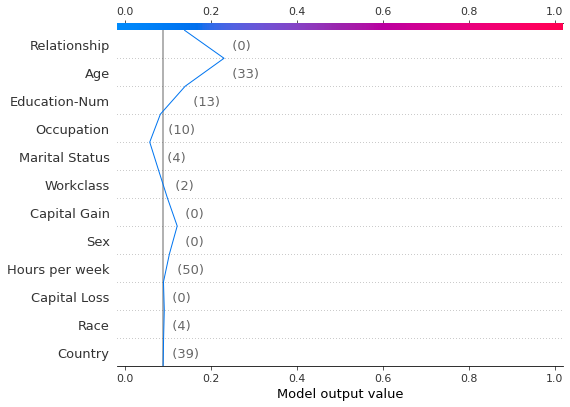

In [22]:
shap.decision_plot(base_value, values, X_train, link='logit')

## Now select the first 10 rows of the dataset to plot the same graph.

You can do that using `values_test[0:10], X_test[0:10]`

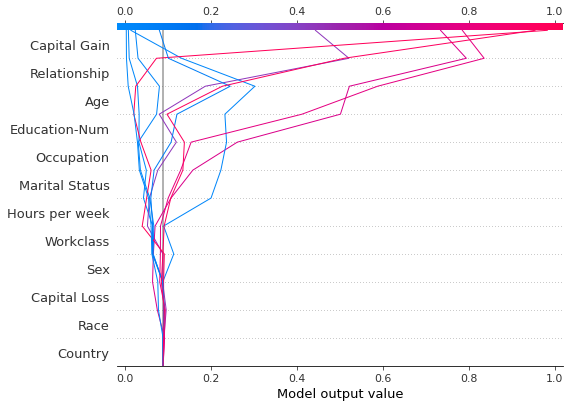

In [25]:
shap.decision_plot(base_value, values_test[0:10], X_test[0:10], link='logit')

# Highlighting 

You can also highlight some observations. For example, if you want to highlight the first observation of your dataset, you can specify its index for the argument `highlight` of the `decision_plot`. The `dashed` lines will be the highlighted observations.

Plot the `decision_plot` for those same 10 rows of your test data highlighting the observation which has the `index=5`.

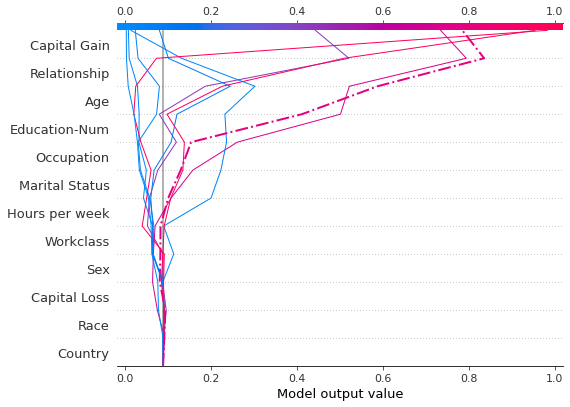

In [28]:
shap.decision_plot(base_value, values_test[0:10], X_test[0:10], highlight=5, link='logit')

# Understanding decisions as a whole

In order to increase our understanding of the decisions, we can use the `shap.summary_plot`.

Specify as arguments to the `shap.summary_plot` the `values_test` and your test dataset to plot a summary of the feature importances.

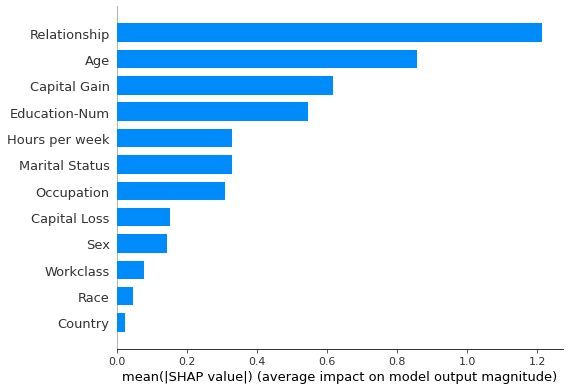

In [31]:
shap.summary_plot(values_test, X_test, plot_type='bar')

For each variable, you can observe how their value affects the predictions. `Blue` points are points in which the feature has a low value. `Red` values are points in which the feature has a high value.

_hint: You can use the argument_ `plot_type = 'violin'` _to see the effects._

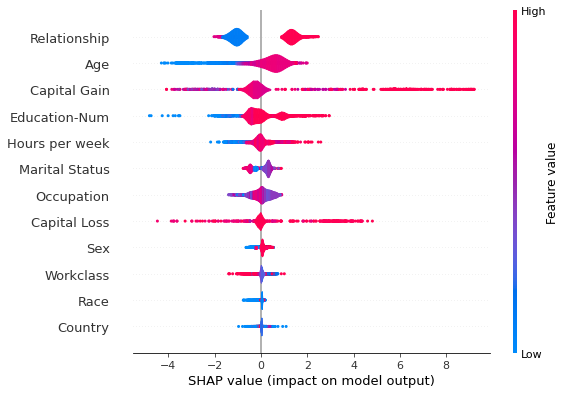

In [32]:
shap.summary_plot(values_test, X_test, plot_type='violin')

# Partial Dependence Plot

The partial dependence plot is used to understand the impact of changing each feature. 

This plot fixes all other variables and varies the variable you choose on the x-direction. In the y-direction, the plot shows the probability (to be precise, the odds) of the event occurring (i.e, in our case, the odds of earning >= $50k).

The color on the plot is related to the interactions of the variable you chose to understand with another variable. By default, it uses the variable in which it sees it has the most correlation.

# Understanding the effect of Age

Use the `shap.dependence_plot` to understand how changing the variable `Age` affects the output of the model.
The `dependence_plot` method receives as arguments the name of the variable, the shap values (you stored in `values_test` for example) and the dataset (in our case, your `test dataset, X_test`). For this first example, also specify the argument `interaction_index=None` to remove the color by now.

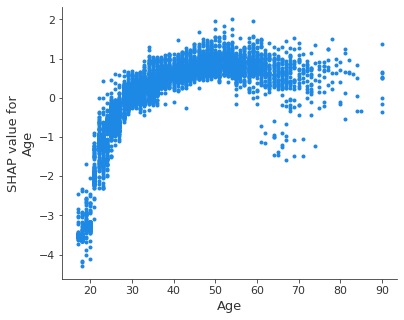

In [33]:
shap.dependence_plot("Age", values_test, X_test, interaction_index=None)

What can you infer from the graph? How changes in `Age` affects the probabilities of earning more than $50k

# Interactions

Substitute `interaction_index=None` by `interaction_index='Education-Num'` to see the interactions between Age and Education. 

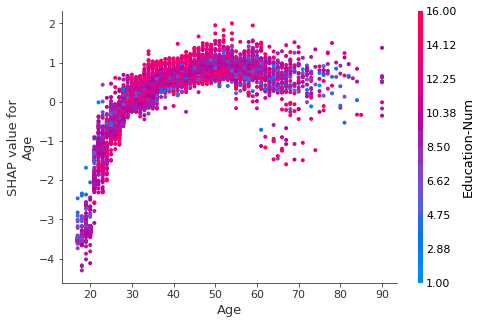

In [34]:
shap.dependence_plot("Age", values_test, X_test, interaction_index='Education-Num')

How do you interpret the graph? For smaller Ages, what values of Education have higher probabilities of earning > $50k? 

And what about as you increase the Age? For higher Ages, what values of Education are more likely to earn > $50k?

Remove the argument `interaction_index` from the argument list of the `dependence_plot` to let SHAP decide which feature have the most interactions with the Age variable.

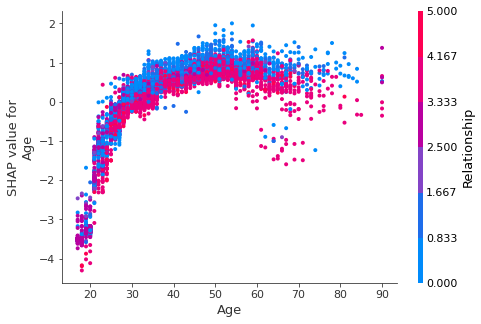

In [35]:
shap.dependence_plot("Age", values_test, X_test)

# BONUS:  Check misclassifications

A practical application of shap values is that they are usefull for understanding where your' models are performing `poorly`. We'll select the observations that our models guessed wrong and try to understand why it did it.

## Selecting observations the model guessed wrong

Using the `model` you created before, you can predict the results for your test dataset.

Use the `model.predict()` method on your test data and store the results on a variable called `y_pred`. You'll be able to compare the predictions on `y_pred` with your actual values stored in `y_test`.

In [36]:
y_pred = model.predict(X_test)

## Comparing results

Create a mask of comparison between `y_pred` and `y_test`. Test whether they are different. It should be an array containing `True` if your model incorrectly predicted the result and `False` if it did right.

Store it in a variable called `misclassifications`

In [42]:
misclassifications = (y_pred == y_test)
misclassifications

array([ True,  True,  True, ...,  True,  True,  True])

## Select a dataset of your misclassifications

Create a new dataset called `X_misclassifications` containing the observations of your `X_test` in which you incorrectly classified the result (i.e., in which the variable `misclassifications` is `True`).

You can obtain that dataset by filtering the `X_test` dataset using the variable `misclassifications`.

In [ ]:
X_misclassifications

# Use the `force_plot` and the `decision_plot` to understand the wrong predictions